# Sock Matching Algorithm Project

In [59]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from rembg import remove
from tqdm import tqdm
from PIL import Image
from collections import deque
import shutil

## Original Image

In [49]:
BASE_DIR = "./Socks_Organized/"

In [50]:
def getImageRec(path):
  return [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(path)) for f in fn]

In [51]:
def displaySample(path, imgCnt=10, seed=42):
    fileInPath = getImageRec(path)
    random.seed(seed)

    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 20))

    # Display the images
    for i in range(imgCnt):
        img = mpimg.imread(random.choice(fileInPath))
        ax = fig.add_subplot(1, imgCnt, i + 1)
        ax.imshow(img)
        ax.axis('off')

    plt.show()

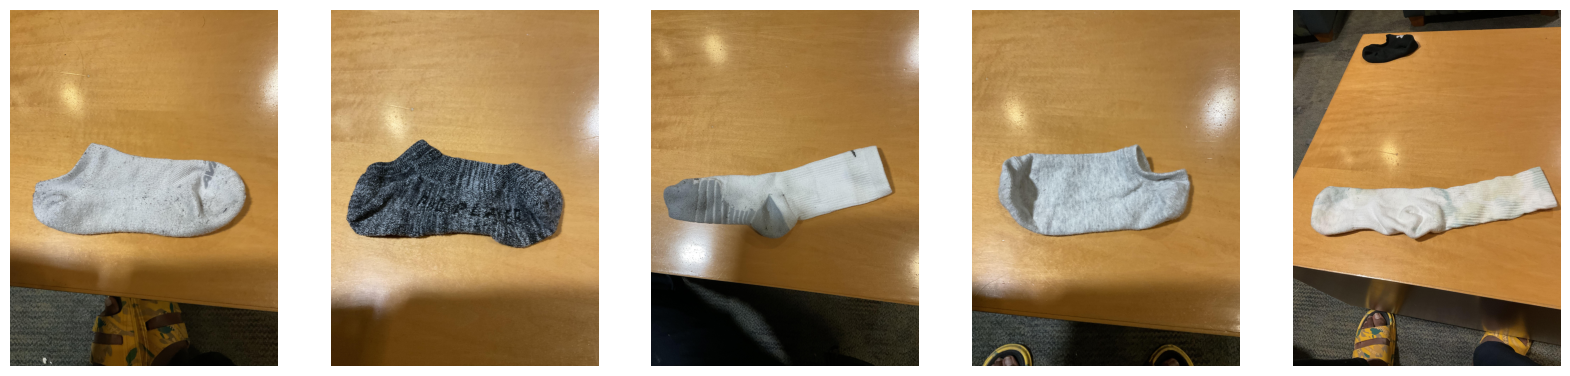

In [52]:
displaySample(BASE_DIR + "JPG/", 5)

## 1. Preprocessing

In [4]:
# # Create folders for the images
# if not os.path.exists("./JPG/"):
#     os.makedirs("./JPG/")

# if not os.path.exists("./Resized/"):
#     os.makedirs("./Resized/")

# if not os.path.exists("./RemBg/"):
#     os.makedirs("./RemBg/")
    
# if not os.path.exists("./Centered/"):
#     os.makedirs("./Centered/")

In [87]:
imagesList = sorted(os.listdir(BASE_DIR + "JPG/"))

cnt = len(imagesList)

uniques = {"IMG_0825.jpg": 6,
           "IMG_0718.jpg": 5,
           "IMG_0839.jpg": 5}

# Categorize into folders
socksInd = 0
while socksInd < cnt:
    folderName = imagesList[socksInd][:-4]
    if not os.path.exists(BASE_DIR + "all_socks/" + folderName):
        os.makedirs(BASE_DIR + "all_socks/" + folderName)
    
    no_of_socks = 4
    if uniques.get(imagesList[socksInd]) != None:
      no_of_socks = uniques[imagesList[socksInd]]
      print(imagesList[socksInd], no_of_socks)
      
    for j in range(no_of_socks):
        if socksInd + j < cnt:
            fileName = imagesList[socksInd + j]
            if not os.path.exists(BASE_DIR + "all_socks/" + folderName + "/" + fileName):
                # Copy the image
                shutil.copy(BASE_DIR + "JPG/" + fileName, BASE_DIR + "all_socks/" + folderName + "/" + fileName)
    socksInd += no_of_socks


IMG_0718.jpg 5
IMG_0825.jpg 6
IMG_0839.jpg 5


In [88]:
# TODO: Separate train left and right socks
# Go to each subfolder and create a folder "Right", "Left"

# path = BASE_DIR + "all_socks/"

# for folder in os.listdir(path):
#     if not os.path.exists(path + folder + "/Right"):
#         os.makedirs(path + folder + "/Right")
#     if not os.path.exists(path + folder + "/Left"):
#         os.makedirs(path + folder + "/Left")
    
#     # Remove the folder "Left" and "Rigth"
#     os.rmdir(path + folder + "/Left")
#     os.rmdir(path + folder + "/Right")
    

### 1.1. Resizing Images

In [89]:
def resize(path, output, size=(512, 512)):
    folderInPath = os.listdir(path)

    for folder in tqdm(folderInPath):
        fileInPath = os.listdir(path + folder)

        for file in fileInPath:
            outputPath = output + folder + "/" + file[:-4] + "_rez" + file[-4:]
            if not os.path.exists(outputPath):
              img = cv2.imread(path + folder + "/" + file)
              img = cv2.resize(img, size)
              cv2.imwrite(outputPath, img)
            
            # Remove old images
            os.remove(path + folder + "/" + file)

In [90]:
resize(BASE_DIR + "all_socks/", BASE_DIR + "all_socks/")

100%|██████████| 62/62 [00:54<00:00,  1.14it/s]


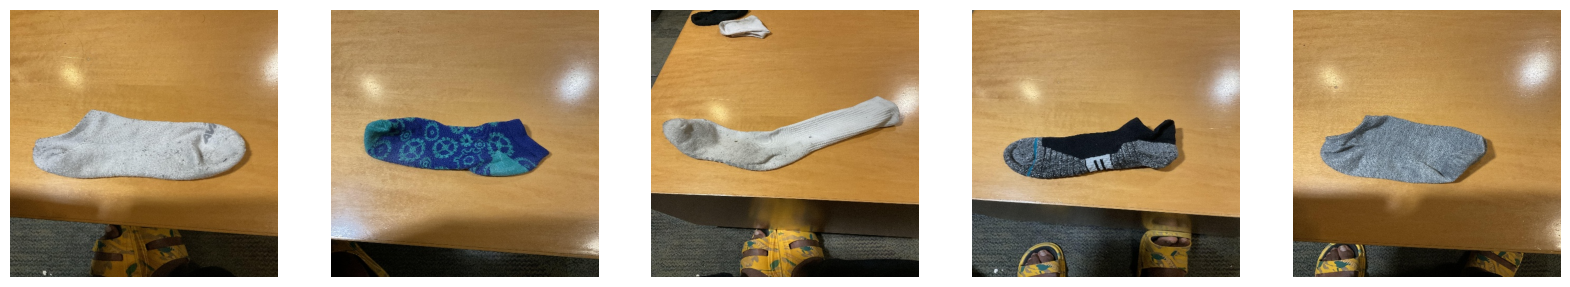

In [91]:
displaySample(BASE_DIR + "all_socks/", 5)

### 1.1. Removing Background and saving the images

In [92]:
def removeBg(path): 
  # TODO: Have a cross on the app 
  files = getImageRec(path)
  print("Number of files: ", len(files))
  print(len(os.listdir(path)))

  for file in tqdm(files):
    if file.endswith(".jpg"):
      jpg_path = file
      output_path = jpg_path[:-4] + "_nobg.png"
    
      if not os.path.exists(output_path):
        # Saving the image with removed background
        input_array = np.array(Image.open(jpg_path))
        result = remove(input_array)
        img = Image.fromarray(result).convert("RGB")
        
        img.save(output_path)
        
        # Removing the original image
        os.remove(jpg_path)
      
      

In [93]:
removeBg(BASE_DIR + "all_socks/")

Number of files:  252
62


  0%|          | 0/252 [00:00<?, ?it/s]

100%|██████████| 252/252 [20:12<00:00,  4.81s/it]   


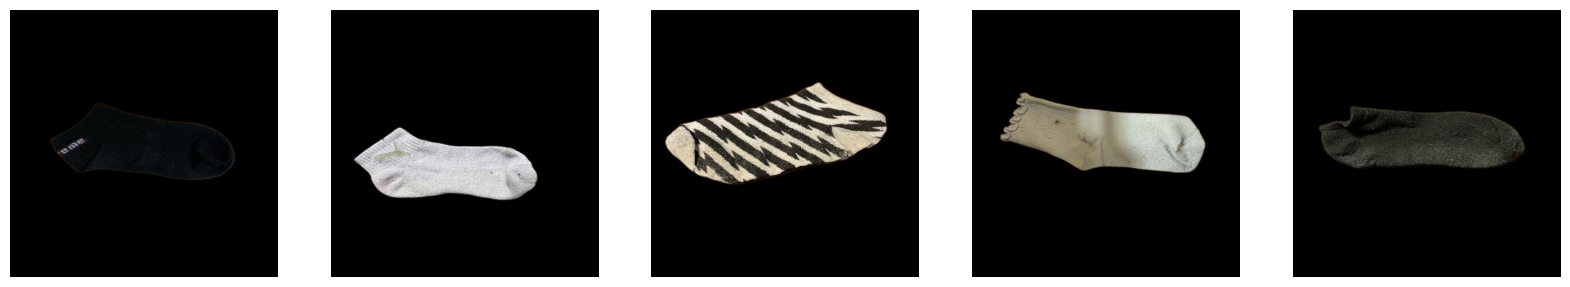

In [95]:
displaySample("./RemBg/", 5)

### 1.2. Centering the images

#### 1.2.1.  By removing the black rows / cols from all 4 sides

In [210]:
def isArrayBlack(arr):
  THRESHOLD = 0.03 # If 95% of the array is black, then it is black
  cnt = np.count_nonzero(np.count_nonzero(arr != [0, 0, 0], axis=1))
  # print(cnt, len(arr) * THRESHOLD, len(arr))
  return cnt < len(arr) * THRESHOLD

def centerImage(imgPath, newPath):
  img = cv2.imread(imgPath)

  np_img = np.array(img)

  # Remove rows / cols with only black pixels

  top = 0
  for i in range(np_img.shape[0]):
    row = np_img[i]
    if not isArrayBlack(row):
      top = i
      break
  
  bottom = len(np_img)
  for i in range(np_img.shape[0] - 1, 0, -1):
    row = np_img[i]
    if not isArrayBlack(row):
      bottom = i
      break
  
  left = 0
  for i in range(np_img.shape[1]):
    col = np_img[:, i]
    if not isArrayBlack(col):
      left = i
      break
  
  right = len(np_img[1])
  for i in range(np_img.shape[1] - 1, 0, -1):
    col = np_img[:, i]
    if not isArrayBlack(col):
      right = i
      break

  # Crop the image
  np_img = np_img[top:bottom, left:right]

  # Save the image
  cv2.imwrite(newPath, np_img)

  # Remove the original image
  # os.remove(imgPath)

#### 1.2.2. By assuming the center of the image is part of the image and BFS out farther till we find a black pixel
- Issue with this could be time complexity

In [99]:
def centerImage(imgPath, newPath):
  img = cv2.imread(imgPath)
  img = cv2.resize(img, (512, 512))
  np_img = np.array(img)

  center_img = np.array([np_img.shape[0] // 2, np_img.shape[1] // 2])

  pixel_queue = deque([center_img])
  visited = {}
  
  top = float("inf")
  bottom = -1
  left = float("inf")
  right = -1

  firstTime = True

  while pixel_queue:
    pixel = pixel_queue.popleft()
    if visited.get(str(pixel)) == True:
      continue

    visited[str(pixel)] = True

    try:
      if pixel[0] >= 0 and pixel[1] >= 0 and pixel[0] < np_img.shape[0] and pixel[1] < np_img.shape[1]:
        if firstTime or np_img[pixel[0]][pixel[1]][0] != 0 or np_img[pixel[0]][pixel[1]][1] != 0 or np_img[pixel[0]][pixel[1]][2] != 0:
          firstTime = False
          
          # Findng top, bottom, left, right coordinates
          top  = min(top, pixel[0])
          bottom = max(bottom, pixel[0])
          left = min(left, pixel[1])
          right = max(right, pixel[1])

          # Going to neighboring pixels (up, down, left, right)
          # TODO: For satefy, you could also go to the diagonally neighboring pixels
          pixel_queue.append([pixel[0] - 1, pixel[1]])
          pixel_queue.append([pixel[0] + 1, pixel[1]])
          pixel_queue.append([pixel[0], pixel[1] - 1])
          pixel_queue.append([pixel[0], pixel[1] + 1])
    except Exception as e:
      print(f"Something went wrong with file {imgPath}")
      break      

  try:
    # Crop the image
    np_img = np_img[top:bottom, left:right]


    # Save the image
    cv2.imwrite(newPath, np_img)
  except Exception as e:
    print(f"Image {imgPath} is not centered or something went wrong")
    print(e)

  # Remove the original image
  # os.remove(imgPath)



In [100]:
def centerImages(path, output):
  files = getImageRec(path)

  for file in tqdm(files):
    newFilePath = output + "/".join(file.split("/")[-2:])

    # Make sure the folder exists
    if not os.path.exists(output + file.split("/")[-2]):
      os.makedirs(output + file.split("/")[-2])

    if not os.path.exists(newFilePath):
      centerImage(file, newFilePath)

In [101]:
centerImages(BASE_DIR + "all_socks/", BASE_DIR + "centered/")

  0%|          | 0/252 [00:00<?, ?it/s]

100%|██████████| 252/252 [00:10<00:00, 23.00it/s]
